In [1]:
from spatialvla.mobilevlm.model.bimanual import load_twinvla_from_singlevla, load_twinvla

[2025-01-09 17:17:41,763] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-01-09 17:17:43.309818: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 17:17:43.339624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 17:17:43.339660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 17:17:43.340558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 17:17:43.346029: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tokenizer, model, image_processor, _ = load_twinvla_from_singlevla('checkpoints/libero_object_octo_full_v2')

You are using a model of type spatialvla to instantiate a model of type twinvla. This is not supported for all configurations of models and can yield errors.


Loading with torch.bfloat16


/home/jellyho/miniconda3/envs/mobilevlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32000. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [2]:
tokenizer, twinvla, image_processor, dataset_statistics = load_twinvla('checkpoints/twinvla_transfer_tissue_v1')

Loading with torch.bfloat16


/home/jellyho/miniconda3/envs/mobilevlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Trainig Code Test

In [3]:
from spatialvla.datasets import RLDSBatchTransform, RLDSDataset
from spatialvla.mobilevlm.model.mobilevlm import load_pretrained_vlm_for_vla, load_vla
from scripts.spatialvla_config import ModelArguments, TrainingArguments
import transformers
from spatialvla.datasets.rlds.utils.data_utils import PaddedCollatorForActionPrediction
from torch.utils.data import DataLoader
from spatialvla.mobilevlm.action_tokenizer import ActionTokenizer
import sys
import torch
import argparse
from PIL import Image
from pathlib import Path
import numpy as np
from spatialvla.mobilevlm.model.mobilevlm import load_vla, load_pretrained_model
from spatialvla.mobilevlm.conversation import conv_templates, SeparatorStyle
from spatialvla.mobilevlm.utils import disable_torch_init, process_images, tokenizer_image_token, KeywordsStoppingCriteria
from spatialvla.mobilevlm.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Tuple, Type
import numpy as np
import torch
import copy
from PIL import Image
from torch.utils.data import Dataset, IterableDataset
from transformers import PreTrainedTokenizerBase
from transformers import AutoTokenizer, BitsAndBytesConfig
from spatialvla.mobilevlm.utils import disable_torch_init, process_images, tokenizer_image_token, KeywordsStoppingCriteria
# from prismatic.models.backbones.llm.prompting import PromptBuilder
# from prismatic.models.backbones.vision import ImageTransform
from spatialvla.mobilevlm.constants import IGNORE_INDEX, IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from spatialvla.mobilevlm.conversation import conv_templates, SeparatorStyle
from spatialvla.datasets.rlds.utils.data_utils import tree_map
# from prismatic.vla.action_tokenizer import ActionTokenizer
from spatialvla.datasets.rlds import make_interleaved_dataset, make_single_dataset
from spatialvla.datasets.rlds.oxe import OXE_NAMED_MIXTURES, get_oxe_dataset_kwargs_and_weights
from spatialvla.datasets.rlds.utils.data_utils import NormalizationType
from transformers import PreTrainedTokenizerBase

In [5]:
batch_transform = RLDSBatchTransform(
    tokenizer,
    image_processor,
    use_state_input=False,
    window_size=1,
    future_action_window_size=7,
)
vla_dataset = RLDSDataset(
    data_root_dir='/home/shared/rlds_datasets',
    data_mix='transfer_tissue',
    batch_transform=batch_transform,
    shuffle_buffer_size=100,
    window_size=1,
    future_action_window_size=7,
    train=True,
    use_state_input=False
)
collator = PaddedCollatorForActionPrediction(
    tokenizer.model_max_length, 
    tokenizer.pad_token_id, 
    padding_side='right', 
    use_state_input=False,
    use_label=False
)
dataloader = DataLoader(
    vla_dataset,
    batch_size=8,
    sampler=None,
    collate_fn=collator,
    num_workers=0,  # Important =>> Set to 0 if using RLDS; TFDS rolls its own parallelism!
)

{'name': 'transfer_tissue', 'data_dir': '/home/shared/rlds_datasets', 'image_obs_keys': {'primary': 'image'}, 'absolute_action_mask': [False, False, False, False, False, False, True, False, False, False, False, False, False, True], 'action_normalization_mask': [True, True, True, True, True, True, False, True, True, True, True, True, True, False], 'action_proprio_normalization_type': <NormalizationType.NORMAL: 'normal'>, 'language_key': 'language_instruction', 'standardize_fn': <function lg_delta_ee_transform at 0x14d52210aa70>}


2025-01-09 17:18:51.441183: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2025-01-09 17:18:51.580253: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization



######################################################################################
# Loading the following 1 datasets (incl. sampling weight):                         #
# transfer_tissue: =========================================================1.000000 #
######################################################################################

Threads per Dataset:  [1]
Reads per Dataset:  [1]
Constructing datasets...


2025-01-09 17:18:51.970955: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Applying frame transforms on dataset...


In [3]:
model.config.training=False
model.config.save_pretrained('checkpoints/twinvla')
model.save_pretrained('checkpoints/twinvla')

In [4]:
tokenizer.save_pretrained('checkpoints/twinvla')

('checkpoints/twinvla/tokenizer_config.json',
 'checkpoints/twinvla/special_tokens_map.json',
 'checkpoints/twinvla/tokenizer.model',
 'checkpoints/twinvla/added_tokens.json')

In [6]:
for d in dataloader:
    batch = d
    break
device_id = 0
input_ids=batch['input_ids'].to(device_id)
images=batch['pixel_values'].to(device_id)
attention_mask=batch['attention_mask'].to(device_id)
actions=batch['action'].to(device_id)
use_cache=True
# states=batch['proprio'].to(device_id)
past_key_values = None
# labels = batch['labels'].to(device_id)

In [ ]:
import torch
if torch.cuda.is_available():
    # Get the current GPU memory usage
    current_memory = torch.cuda.memory_allocated()  # Memory currently allocated by tensors
    reserved_memory = torch.cuda.memory_reserved()  # Total memory reserved by PyTorch
    max_memory = torch.cuda.max_memory_allocated()  # Peak memory usage for allocated tensors

    # Convert to MB for readability
    current_memory_mb = current_memory / (1024 ** 2)
    reserved_memory_mb = reserved_memory / (1024 ** 2)
    max_memory_mb = max_memory / (1024 ** 2)

    print(f"Current Memory Allocated: {current_memory_mb:.2f} MB")
    print(f"Reserved Memory: {reserved_memory_mb:.2f} MB")
    print(f"Peak Memory Allocated: {max_memory_mb:.2f} MB")

In [9]:
with torch.autocast('cuda', dtype=torch.bfloat16):
    action, attn  = twinvla.predict_action(
        input_ids=input_ids,
        attention_mask=attention_mask,
        images=images,
        output_attn=True
        # actions=actions
    )

In [81]:
def attn_viz_array(attn_mat, width, head=0):
    seq_len = attn[0].shape[-1]
    half_len = seq_len // 2
    matrix_list = torch.zeros((16 , 24, half_len))
    for i in range(24):
        for h in range(16):
            matrix_list[h, i] = attn_mat[i][0, h][half_len-1, half_len:]
    matrix_list = matrix_list.detach().cpu().numpy()
    seq_len = matrix_list.shape[-1]
    layers = 24
    dpi = 100
    figsize = (width / dpi, width / seq_len * layers / dpi)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(matrix_list[head], vmin=0.0, vmax=0.01, interpolation='nearest')
    ax.axis('off')
    fig.tight_layout(pad=0)  # Remove padding between the figure and the edges
    fig.canvas.draw()
    image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image_array

In [50]:
def visualize_attention(attn_mat):
    seq_len = attn[0].shape[-1]
    half_len = seq_len // 2
    matrix_list = torch.zeros((16 , 24, half_len))
    for i in range(24):
        for h in range(16):
            # attn_mat = attn[i][0, j]
            matrix_list[h, i] = attn_mat[i][0, h][half_len-1, half_len:]
    return matrix_list

In [82]:
attn_mat = attn_viz_array(attn, 400)

/tmp/ipykernel_2793302/1747751883.py:20: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


""

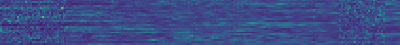

In [83]:
import mediapy
mediapy.show_image(attn_mat)

In [64]:
attn_mat.shape

(16, 24, 211)

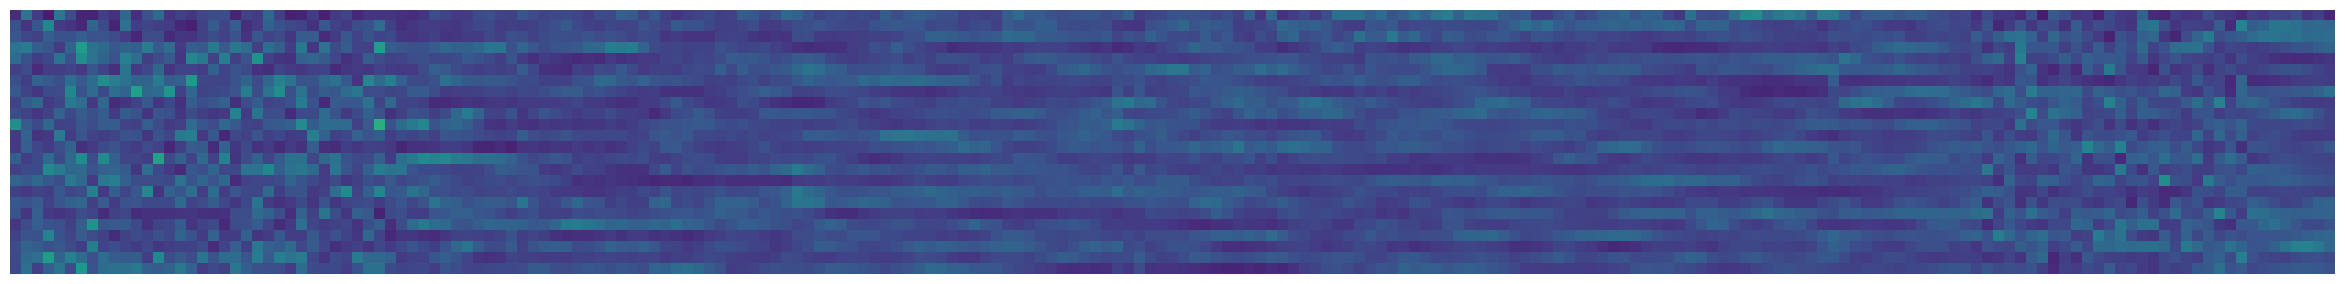

In [63]:
import matplotlib.pyplot as plt

# plt.imshow(attn_mat[0]//

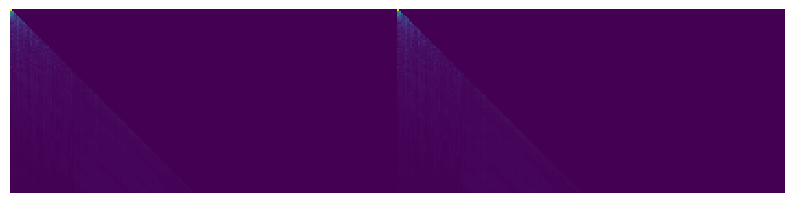

In [45]:
plt.figure(figsize=(10, 10))  # Set figure size (width, height in inches)
plt.imshow(attn[-1][0][0][0:100].detach().cpu().float().numpy(), interpolation='nearest')
plt.axis('off')  # Turn off axis
plt.show()